### continued from 'cleaning genre tags'...

In [ ]:
df = pd.read_csv('everything_scraped_with_cleangenre')

## just 1 rating for each track

In [ ]:
# when we engineer the columns from Billboard charts, ideally we would have a time series style score for a track's progress
# in the charts. However, because what we are predicting is stagnant: Spotify popularity from the time of the scrape (2019),
# we cannot have a cumulative track longevity and artist familiarity score. If we were predicting the cumulative number of 
# plays then we would be able to have such a cumulative score. So. because of the data availible I will have 1 Billboard score 
# per track.

In [ ]:
# (more explanation about 'track longevity')

In [8]:
just_one = df.drop(['month', 'year', 'rank_', 'weeks_on_chart', 'instance'], axis=1)
just_one = just_one.drop_duplicates(subset='track_name', keep='first').reset_index(drop=True)

In [9]:
just_one.shape

(16032, 20)

In [10]:
len(just_one.artist.unique())

2930

In [11]:
len(just_one.track_name.unique())

16032

# -----------------------------------------------------------------------------------------

# feature engineering

## track longevity

#### (101 - rank) * weeks on chart

In [74]:
time = df[['artist', 'track_name', 'weekid', 'rank_', 'weeks_on_chart', 'instance']]
rank_system = time.groupby(['artist','track_name', 'instance'])[['rank_', 'weeks_on_chart']].agg({
    'weeks_on_chart': 'max', 'rank_':'mean'})
rank_system.reset_index(inplace=True, drop=False)
score = rank_system.weeks_on_chart * (101 - rank_system.rank_)
rank_system['track_longevity'] = score
rank_system[rank_system.track_name == 'Sail']

,artist,track_name,instance,weeks_on_chart,rank_,track_longevity
244,AWOLNATION,Sail,1,20,90.050000,219.00000
245,AWOLNATION,Sail,2,79,36.959184,5059.22449


#### sort out multiple instances

In [75]:
instances = rank_system.groupby(['artist', 'track_name'])[['rank_', 'weeks_on_chart', 'track_longevity']].agg({
    'weeks_on_chart': 'max', 'rank_':'mean', 'track_longevity':'sum'})
instances.reset_index(inplace=True, drop=False)
instances[instances.track_name == 'Sail']

,artist,track_name,weeks_on_chart,rank_,track_longevity
223,AWOLNATION,Sail,79,63.504592,5278.22449


In [131]:
just_one[just_one.artist == 'Mariah Carey'][just_one.track_name == 'All I Want for Christmas Is You'][['artist', 'track_name', 'track_longevity', 'spotify_track_pop']]

,artist,track_name,track_longevity,spotify_track_pop
353,Mariah Carey,All I Want for Christmas Is You,8702.2,88.0


In [76]:
instances.sort_values(by='track_longevity', ascending=False).head()

,artist,track_name,weeks_on_chart,rank_,track_longevity
10079,Mark Ronson,Uptown Funk,56,17.100000,9308.000000
10021,Mariah Carey,All I Want for Christmas Is You,29,30.243750,8702.200000
886,Avicii,Wake Me Up,54,27.896226,7816.000000
2174,Brenda Lee,Rockin' Around The Christmas Tree,27,42.912500,7579.266667
12133,Queen,Bohemian Rhapsody - Remastered 2011,44,32.624183,7454.058824


In [1164]:
just_one = pd.merge(just_one, instances[['artist', 'track_name', 'track_longevity']], how='inner', 
                    left_on=['artist','track_name'], 
                    right_on=['artist','track_name'])

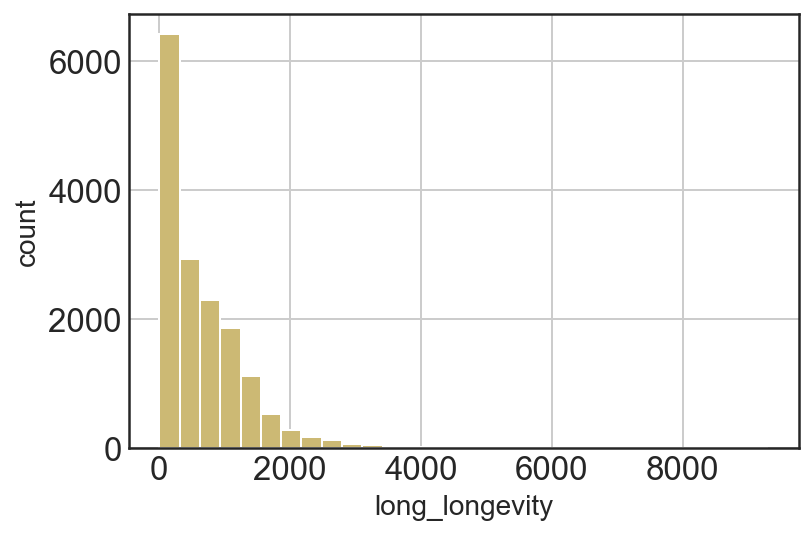

In [67]:
just_one.track_longevity.hist(bins=30, color='y');
plt.xlabel('long_longevity', fontsize=14)
plt.ylabel('count', fontsize=14);

#### showing Mariah Carey's cumulative track longevity (for presentation)

In [129]:
rank_system_grouped = rank_system.groupby(['artist'])[['track_longevity']].apply(lambda x: x.cumsum())
rank_system_grouped['artist'] = rank_system.artist
rank_system_grouped['artist'] = rank_system.artist
rank_system_grouped['track_name'] = rank_system.track_name
rank_system_grouped['instance'] = rank_system.instance
rank_system_grouped['weeks_on_chart'] = rank_system.weeks_on_chart
rank_system_grouped[rank_system_grouped.artist == 'Mariah Carey'].iloc[1:5]

,track_longevity,artist,track_name,instance,weeks_on_chart
10899,1045.000000,Mariah Carey,All I Want for Christmas Is You,1,1
10900,1349.000000,Mariah Carey,All I Want for Christmas Is You,2,4
10901,1871.666667,Mariah Carey,All I Want for Christmas Is You,3,7
10902,2465.000000,Mariah Carey,All I Want for Christmas Is You,4,10


#### illustration of cumulative play counts (for presentation)

In [ ]:
# cant use cumulative track longevity because as the track longevity gets higher, spotify_track_pop stays the same

In [122]:
pd.DataFrame([100000, 300000, 500000, 900000], columns=['cumulative play count'])

,cumulative play count
0,100000
1,300000
2,500000
3,900000


In [ ]:
# but if we were predicting this then the track longevity could be cumulative

# -----------------------------------------------------------------------------------------

## artist familiarity

In [1167]:
rank_system_2 = time.groupby(['artist', 'instance'])[['rank_', 'weeks_on_chart']].agg({
    'weeks_on_chart': 'max', 'rank_':'mean'})
rank_system_2.reset_index(inplace=True, drop=False)
artist_fam = rank_system_2.weeks_on_chart * (101 - rank_system_2.rank_) 
rank_system_2['artist_familiarity'] = artist_fam
palace = rank_system_2.groupby('artist')[['rank_', 'weeks_on_chart', 'artist_familiarity']].agg({
    'weeks_on_chart': 'max', 'rank_':'mean', 'artist_familiarity':'sum'})
palace.reset_index(inplace=True, drop=False)
palace.sort_values(by='artist_familiarity', ascending = False).head(10)

,artist,weeks_on_chart,rank_,artist_familiarity
1135,Imagine Dragons,87,35.772111,12797.694306
1679,Mariah Carey,43,27.064091,12042.669534
55,Adele,65,42.552255,11524.813128
2472,Taylor Swift,50,46.010420,9060.457804
355,Brenda Lee,27,43.468948,8888.928710
1686,Mark Ronson,56,21.727941,8798.926471
799,Ed Sheeran,58,25.076357,8638.778940
1477,LMFAO,68,48.417853,8313.056452
1412,Kelly Clarkson,46,29.924248,8086.144212
828,Ellie Goulding,57,37.369444,8078.377577


In [1168]:
just_one = pd.merge(just_one, palace[['artist', 'artist_familiarity']], how='inner', on='artist')

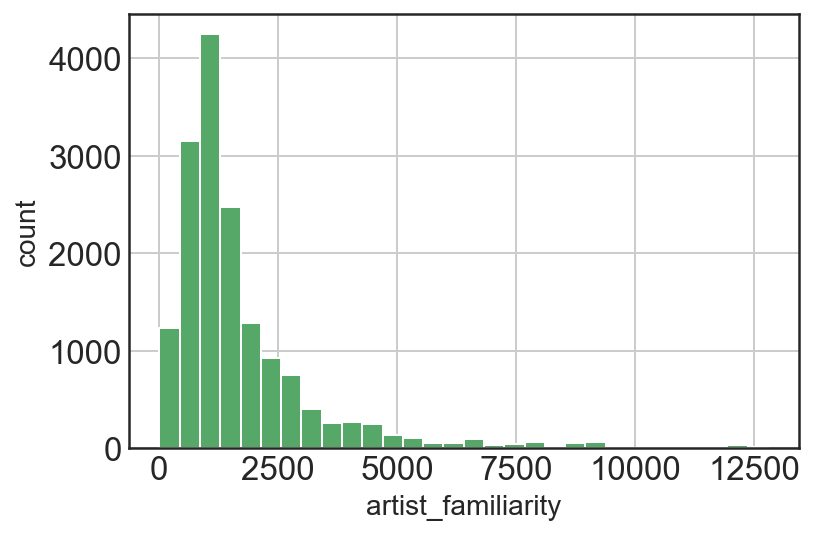

In [66]:
just_one.artist_familiarity.hist(bins=30, color='g');
plt.xlabel('artist_familiarity', fontsize=14)
plt.ylabel('count', fontsize=14);

# -----------------------------------------------------------------------------------------

## peak chart position

In [133]:
peak_system = time.groupby(['artist','track_name', 'instance'])['rank_'].agg({'rank_':'min'})
peak_system.reset_index(inplace=True, drop=False)
peak_system = peak_system.groupby(['artist', 'track_name'])['rank_'].agg({'peak_rank':'min'}) # sneaky way to rename
peak_system.reset_index(inplace=True, drop=False)
peak_system[peak_system.peak_rank == 1].head()

,artist,track_name,peak_rank
111,50 Cent,21 Questions,1
114,50 Cent,Candy Shop,1
121,50 Cent,In Da Club,1
156,? & The Mysterians,96 Tears,1
175,A Taste Of Honey,Boogie Oogie Oogie - Single Version 2 / Remast...,1


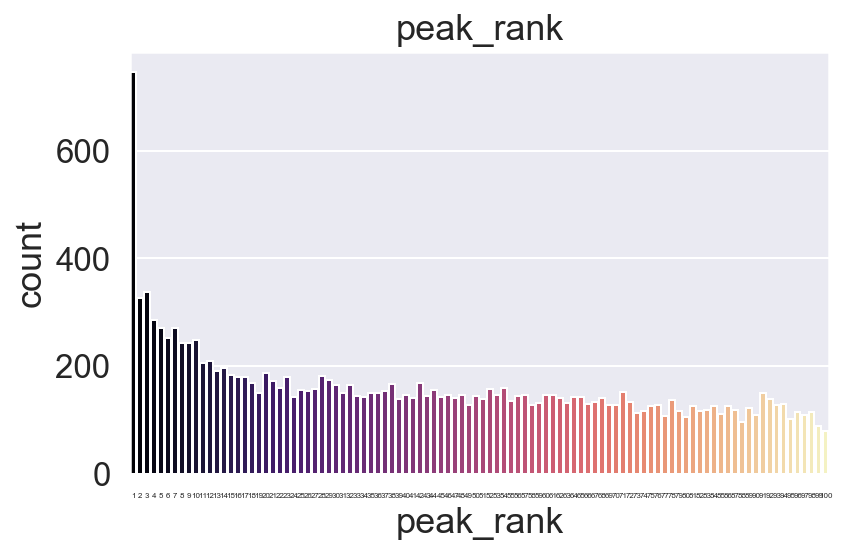

In [1271]:
ax = sns.countplot(x="peak_rank", data=just_one, palette = 'magma')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=4)
plt.title('peak_rank')
plt.tight_layout()
plt.show()

In [1171]:
just_one = pd.merge(just_one, peak_system[['artist', 'track_name', 'peak_rank']], how='inner', 
                    left_on=['artist','track_name'], 
                    right_on=['artist','track_name'])

# -----------------------------------------------------------------------------------------

### TIME SINCE FIRST CHARTING

In [1182]:
just_one['weekid'] = pd.to_datetime(just_one.weekid, format='%Y%m%d', errors='coerce')
just_one['time'] =  just_one.weekid.apply(lambda x: just_one.weekid.max().toordinal() - x.toordinal())

# -----------------------------------------------------------------------------------------

## genre dominance

In [ ]:
# genre dominance would be very helpful for predicting a cumulative billboard popularity
# but since we have had to have 1 row per song, this feature becomes useless because our model is no longer a timeseries 
# and it would be cheating to have the whole genre's total popularity for all 50 years as the 1 number in the row.

#### percentage of songs by genre 


In [53]:
genre_dummy = pd.get_dummies(df['genre'])
song_date = df.weekid
song_date = genre_dummy.join(song_date)
song_group = song_date.groupby('weekid').agg('sum')
song_group.head(3)

,adult standards,blues,classical,country,dance,dancehall,disco,electronic,folk,freestyle,funk,grunge,hip hop,house,indie,jazz,metal,pop,punk,rap,reggae,rock,ska,soul,trance,trap
weekid,,,,,,,,,,,,,,,,,,,,,,,,,,
1958-08-02,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,2,12,0,3,0,18,0,2,0,0
1958-08-09,0,1,0,10,0,0,0,0,0,0,0,0,2,0,0,0,2,12,0,3,1,18,0,4,0,0
1958-08-16,0,0,1,7,0,0,0,0,0,0,0,0,1,0,0,0,2,14,0,2,0,14,0,2,0,0


In [957]:
percentages = {}
for genre in song_group.columns:    
    percentages[genre] = song_group.apply(lambda x: x[genre]/sum(x), axis=1)
genre_percent = pd.DataFrame(percentages)
genre_percent.head(1)

,adult standards,blues,classical,country,dance,dancehall,disco,electronic,folk,freestyle,funk,grunge,hip hop,house,indie,jazz,metal,pop,punk,rap,reggae,rock,ska,soul,trance,trap
weekid,,,,,,,,,,,,,,,,,,,,,,,,,,
1958-08-02,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.053571,0.339286,0.0,0.071429,0.0,0.321429,0.0,0.071429,0.0,0.0


In [958]:
df_new = pd.merge(df[['genre', 'weekid']], genre_percent, left_on='weekid', right_on=genre_percent.index, how='inner')

In [959]:
def find_genre(x):
    matched = x['genre']
    return x[matched]
genre_percent = df_new.apply(lambda x: find_genre(x), axis=1)
genre_percent = pd.DataFrame({'genre_percent':genre_percent})
genre_percent.head()

,genre_percent
0,0.298969
1,0.298969
2,0.298969
3,0.288660
4,0.010309


In [960]:
df.reset_index(inplace=True, drop=True)
genre_percent.reset_index(inplace=True, drop=True)
df = pd.merge(df, genre_percent, left_on=df.index, right_on=genre_percent.index)
df.drop(['key_0'], inplace=True, axis=1)

#### save tracks to csv

In [1186]:
just_one.to_csv('ready_to_model_just_one', encoding='utf-8', index=False)

#### load tracks from csv

In [14]:
just_one = pd.read_csv('ready_to_model_just_one')